## Library:

In [ ]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import networkx as nx
from fastprogress import master_bar, progress_bar
from networkx.algorithms import centrality

from collections import defaultdict
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
G = nx.readwrite.edgelist.read_weighted_edgelist('graph.edgelist')

In [ ]:
num_tops = 10

## Dataset:

In [ ]:
df_anime = pd.read_csv("anime.csv")
df_rating = pd.read_csv("rating.csv")

In [ ]:
display(df_anime.head())
display(df_rating.head())

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


In [ ]:
df_rating.dropna(inplace=True)

In [ ]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

In [ ]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
rating_value_counts = df_rating[df_rating['rating'] == -1].rating.value_counts()

In [ ]:
rating_df_rating = df_rating[df_rating['rating'] == -1 ]
rating_count = rating_value_counts[-1]

In [ ]:
# new dataframe without user-item intercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - rating_count)

df_rating = new_df_rating
del new_df_rating

In [ ]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items
print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  12795
Number of edges:  509576


### 1.1 Degree centrality:

In [ ]:
%%time
degree_centrality = centrality.degree_centrality(G)

CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 24.8 ms


In [ ]:
# Sort dictionary by value
degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(degree_centrality, orient='index')
_.to_csv('/content/degree.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_degreeU = []
top_degreeA = []

for k in degree_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_degreeU.append((k, degree_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_degreeA.append((k, degree_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_degreeU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_degreeA:
  print('{}    {}'.format(k,v))

Top users:
user_7345    0.15182198887430465
user_1530    0.09900618788674292
user_2951    0.08825551596974811
user_8217    0.08769298081130071
user_8115    0.08363022688918058
user_7114    0.07669229326832927
user_6569    0.0742546409150572
user_7511    0.07375460966310395
user_7247    0.0722545159072442
user_5310    0.07212950809425589
--------------

Top anime:
anime_1535    0.259016188511782
anime_1575    0.19232452028251765
anime_16498    0.18957434839677478
anime_11757    0.18613663353959622
anime_226    0.18507406712919558
anime_121    0.17263578973685856
anime_2904    0.17201075067191698
anime_20    0.16907306706669167
anime_6547    0.15732233264579035
anime_4224    0.15394712169510594


### 1.2 Closeness centrality

In [ ]:
def cost_path(G, edges_list, weight=None):
  result = 0
  if weight != None:
    for i in range(1, len(edges_list)):
      v = edges_list[i-1]
      u = edges_list[i]
      result += G[v][u][weight]
  else:
    result = len(edges_list) - 1
  return result


In [ ]:
rd.seed(1)

def approximateClosenessCentralities(G, k, weight=None):
  sum_v = defaultdict()
  for v in G.nodes:
    sum_v[v] = 0

  for i in range(k):
    v_i = rd.choice(list(G.nodes))

    if weight != None: sssp = nx.algorithms.shortest_paths.generic.shortest_path(G, source=v_i,weight=weight, method='dijkstra')
    else: sssp = nx.algorithms.shortest_paths.generic.shortest_path(G, source=v_i,weight=None)

    for v in G.nodes:
      if weight != None: sum_v[v] += cost_path(G, sssp[v], weight)
      else: sum_v[v] += cost_path(G, sssp[v])

  cc = defaultdict() #closeness centrality
  n = len(G.nodes)
  for v in G.nodes:
    if sum_v[v] != 0:
      cc[v] = 1 / ((n * sum_v[v]) / (k *(n-1)))
    else:
      cc[v] = 1

  return cc

#### Without weights:

In [ ]:
%%time
k = 150
closeness_centrality = approximateClosenessCentralities(G, 150)

CPU times: user 1min 6s, sys: 234 ms, total: 1min 7s
Wall time: 1min 8s


In [ ]:
# Sort dictionary by value
closeness_centrality = {k: v for k, v in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centrality, orient='index')
_.to_csv('/content/closeness.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))

Top users:
user_7345    0.4504222972972973
user_5310    0.4322496397694524
user_7366    0.4322496397694524
user_6869    0.4297725644699141
user_7114    0.4297725644699141
user_8115    0.4297725644699141
user_5669    0.42732371794871793
user_5908    0.42732371794871793
user_6474    0.42732371794871793
user_1497    0.42490262039660054
--------------

Top anime:
anime_1535    0.4822849678456591
anime_11757    0.4731565457413249
anime_226    0.4701900470219436
anime_20    0.46726051401869156
anime_1575    0.45589855623100306
anime_16498    0.45314388217522655
anime_30    0.4504222972972973
anime_4224    0.4504222972972973
anime_2904    0.4477332089552239
anime_3588    0.4372904518950437


#### With weights (ratings in this case):

In [ ]:
%%time
k = 150
closeness_centrality = approximateClosenessCentralities(G, 150, 'weight')

CPU times: user 5min 28s, sys: 1.21 s, total: 5min 29s
Wall time: 5min 35s


In [ ]:
# Sort dictionary by value
closeness_centrality = {k: v for k, v in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centrality, orient='index')
_.to_csv('/content/closenessW.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))


Top users:
user_5    0.12974967560553632
user_5137    0.12754304846938774
user_6869    0.12395919421487603
user_4512    0.12244132653061225
user_4168    0.1214498987854251
user_271    0.12057124196141478
user_6618    0.1199925
user_3925    0.11989658273381296
user_1938    0.11970520750199522
user_99    0.11960974880382776
--------------

Top anime:
anime_19315    0.12541022157190634
anime_413    0.1249921875
anime_25429    0.12437033582089552
anime_2476    0.12314501231527093
anime_21033    0.12204281936533766
anime_225    0.1214498987854251
anime_15609    0.12096018145161291
anime_20457    0.12096018145161291
anime_18857    0.12086271152296536
anime_4975    0.12047439759036144


#### With weights (ratings function):

    f(x) = -x^{2} + 110

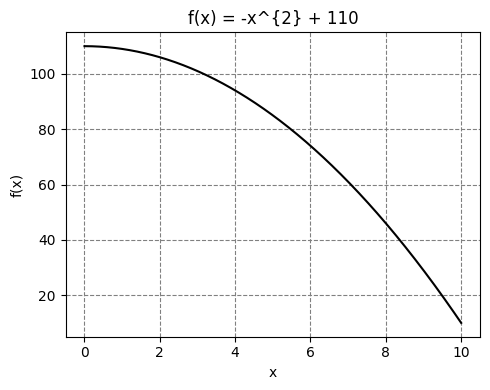

In [ ]:

x = np.linspace(0, 10, 1000)
y = -x**2+110
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(x, y, color='k')

'''
# highlight
x = np.linspace(0, 10, 1000)
y = -x**2+110
ax.fill_between(x, y-2, y+2, color='limegreen', alpha=0.5)
'''

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'f(x) = -x^{2} + 110')
plt.grid(color='gray', linestyle='--')
plt.tight_layout()
plt.savefig('/content/function_weights.jpg')
plt.show()

In [ ]:
G_prime = G.copy()
for e in progress_bar(list(G_prime.edges(data=True))):
  v = e[0] #node
  u = e[1] #node
  w = e[2]['weight']

  # apply function f(x) = -x^2+110
  w2 = -w**2+110

  # update weight on the graph
  G_prime[v][u]['weight'] = w2

#### Centrality computation:

In [ ]:
%%time
k = 150
closeness_centralityFW = approximateClosenessCentralities(G_prime, 150, 'weight')

CPU times: user 5min 23s, sys: 1.02 s, total: 5min 24s
Wall time: 5min 32s


In [ ]:
# Sort dictionary by value
closeness_centralityFW = {k: v for k, v in sorted(closeness_centralityFW.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centralityFW, orient='index')
_.to_csv('/content/closenessFW.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centralityFW.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centralityFW[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centralityFW[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))

Top users:
user_6969    0.027668442169341452
user_6299    0.027566738650983275
user_3657    0.027320696721311474
user_7114    0.027300805424099017
user_6162    0.027256155733236413
user_7347    0.02725120367005814
user_2873    0.02719191896301668
user_6152    0.027118174832760803
user_8001    0.02708389761646804
user_7716    0.027079007943672143
--------------

Top anime:
anime_1535    0.027516166758392954
anime_2904    0.02670773237179487
anime_1575    0.026388216924700916
anime_199    0.026300302472382957
anime_9253    0.02624048722883135
anime_5114    0.02581594234079174
anime_4224    0.025762731879079355
anime_2001    0.02567892912172573
anime_16498    0.025569489430617116
anime_121    0.02549993624617477


### 1.3 Degree centrality - Bipartite:

#### Computation:

In [ ]:
# Add user node features
for i in df_rating.user_id.unique():
  attrs = {'user_' + str(i): {'node_type':'user'}}
  nx.set_node_attributes(G, attrs)

# Add anime node features
for i in df_rating.anime_id.unique():
  attrs = {'anime_' + str(i): {'node_type':'anime'}}
  nx.set_node_attributes(G, attrs)

In [ ]:
anime_nodes = []
for id,t in G.nodes(data='node_type'):
  if t == 'anime':
    anime_nodes.append(id)

In [ ]:
%%time
degree_centrality = nx.algorithms.bipartite.centrality.degree_centrality(G, anime_nodes)

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 42.6 ms


In [ ]:
# Sort dictionary by value
degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(degree_centrality, orient='index')
_.to_csv('/content/degreeB.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_degreeU = []
top_degreeA = []

for k in degree_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_degreeU.append((k, degree_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_degreeA.append((k, degree_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_degreeU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_degreeA:
  print('{}    {}'.format(k,v))

Top users:
user_7345    0.34361295798557084
user_1530    0.22407695572216724
user_2951    0.1997453670957703
user_8217    0.1984722025746216
user_8115    0.18927712547743672
user_7114    0.17357476304993635
user_6569    0.16805771679162543
user_7511    0.1669260149950488
user_7247    0.16353090960531902
user_5310    0.16324798415617486
--------------

Top anime:
anime_1535    0.46400179151270854
anime_1575    0.34453028776172884
anime_16498    0.3396036278132348
anime_11757    0.3334453028776173
anime_226    0.33154182062479004
anime_121    0.30925988131228305
anime_2904    0.30814018586944353
anime_20    0.30287761728809764
anime_6547    0.28182734296271417
anime_4224    0.2757809875713806


### 1.4 Top anime Comparison

In [ ]:
df_anime.sort_values(by=['rating'], ascending=False).iloc[:10, 5]

10464    10.00
10400     9.60
9595      9.50
0         9.37
9078      9.33
1         9.26
2         9.25
10786     9.25
3         9.17
4         9.16
Name: rating, dtype: float64

In [ ]:
prefA_r = []
for i in df_anime.sort_values(by=['rating'], ascending=False).iloc[:10, 5].index:
  name = df_anime.at[i, 'name']
  prefA_r.append(name)

In [ ]:
df_anime.sort_values(by=['members'], ascending=False).iloc[:10, 6]

40     1013917
86      896229
804     893100
1       793665
159     717796
19      715151
841     683297
3       673572
445     657190
131     633817
Name: members, dtype: int64

In [ ]:
prefA_m = []
for i in df_anime.sort_values(by=['members'], ascending=False).iloc[:10, 6].index:
  name = df_anime.at[i, 'name']
  prefA_m.append(name)

### 1.5 Final considerations

In [ ]:
# Load data
degree = pd.read_csv('./degree.csv', names=['ids', 'score'])
degreeB = pd.read_csv('./degreeB.csv', names=['ids', 'score'])
closeness = pd.read_csv('./closeness.csv', names=['ids', 'score'])
closenessW = pd.read_csv('./closenessW.csv', names=['ids', 'score'])
closenessFW = pd.read_csv('./closenessFW.csv', names=['ids', 'score'])

In [ ]:
def retrieve_topK(df, df_description, num_tops):
  u = 0 #top users
  a = 0 #top anime

  topU = []
  topA = []

  for k in df['ids'].to_list():
    if k[:4] == 'user' and u < num_tops:
      u += 1
      topU.append(k)
    elif k[:5] == 'anime' and a < num_tops:
      a += 1

      i = df_description[df_description['anime_id'] == int(k[6:])].index[0]
      name = df_description.at[i, 'name']

      topA.append(name)
    if u == num_tops and a == num_tops:
      break

  return [topU, topA]

In [ ]:
d_u = defaultdict()
d_a = defaultdict()

# degree
topU, topA = retrieve_topK(degree, df_anime, num_tops)
d_u['degree'] = topU
d_a['degree'] = topA

# degree B
topU, topA = retrieve_topK(degreeB, df_anime, num_tops)
d_u['degree B'] = topU
d_a['degree B'] = topA

# closeness
topU, topA = retrieve_topK(closeness, df_anime, num_tops)
d_u['closeness'] = topU
d_a['closeness'] = topA

# closeness W
topU, topA = retrieve_topK(closenessW, df_anime, num_tops)
d_u['closeness W'] = topU
d_a['closeness W'] = topA

# closeness FW
topU, topA = retrieve_topK(closenessFW, df_anime, num_tops)
d_u['closeness FW'] = topU
d_a['closeness FW'] = topA

# global average ranking
d_a['global avg rank'] = prefA_r

# members
d_a['members'] = prefA_m


In [ ]:
df_top_anime = pd.DataFrame(d_a)
df_top_user = pd.DataFrame(d_u)

**Top-k users rankings**

In [ ]:
df_top_user

,degree,degree B,closeness,closeness W,closeness FW
0,user_7345,user_7345,user_7345,user_5,user_6969
1,user_1530,user_1530,user_5310,user_5137,user_6299
2,user_2951,user_2951,user_7366,user_6869,user_3657
3,user_8217,user_8217,user_6869,user_4512,user_7114
4,user_8115,user_8115,user_7114,user_4168,user_6162
5,user_7114,user_7114,user_8115,user_271,user_7347
6,user_6569,user_6569,user_5669,user_6618,user_2873
7,user_7511,user_7511,user_5908,user_3925,user_6152
8,user_7247,user_7247,user_6474,user_1938,user_8001
9,user_5310,user_5310,user_1497,user_99,user_7716


 **Top-k anime rankings**

In [ ]:
df_top_anime

,degree,degree B,closeness,closeness W,closeness FW,global avg rank,members
0,Death Note,Death Note,Death Note,Pupa,Death Note,Taka no Tsume 8: Yoshida-kun no X-Files,Death Note
1,Code Geass: Hangyaku no Lelouch,Code Geass: Hangyaku no Lelouch,Sword Art Online,Hametsu no Mars,Code Geass: Hangyaku no Lelouch R2,Spoon-hime no Swing Kitchen,Shingeki no Kyojin
2,Shingeki no Kyojin,Shingeki no Kyojin,Elfen Lied,Isuca,Code Geass: Hangyaku no Lelouch,Mogura no Motoro,Sword Art Online
3,Sword Art Online,Sword Art Online,Naruto,School Days,Sen to Chihiro no Kamikakushi,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood
4,Elfen Lied,Elfen Lied,Code Geass: Hangyaku no Lelouch,Seikoku no Dragonar,Steins;Gate,Kahei no Umi,Angel Beats!
5,Fullmetal Alchemist,Fullmetal Alchemist,Shingeki no Kyojin,Dragon Ball GT,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,Code Geass: Hangyaku no Lelouch
6,Code Geass: Hangyaku no Lelouch R2,Code Geass: Hangyaku no Lelouch R2,Neon Genesis Evangelion,"Kono Naka ni Hitori, Imouto ga Iru!: Ani, Imou...",Toradora!,Gintama°,Naruto
7,Naruto,Naruto,Toradora!,"Inari, Konkon, Koi Iroha.",Tengen Toppa Gurren Lagann,Yakusoku: Africa Mizu to Midori,Steins;Gate
8,Angel Beats!,Angel Beats!,Code Geass: Hangyaku no Lelouch R2,Ore no Imouto ga Konnani Kawaii Wake ga Nai. S...,Shingeki no Kyojin,Steins;Gate,Mirai Nikki (TV)
9,Toradora!,Toradora!,Soul Eater,ChäoS;HEAd,Fullmetal Alchemist,Gintama&#039;,Toradora!


**1.5.1 A Similarity Measure for Indefinite Rankings (RBO)**

In [ ]:
import math
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

**User**

In [ ]:
categories = ['degree', 'degree B', 'closeness', 'closeness W', 'closeness FW']
rbo_values = np.zeros((len(categories), len(categories)), dtype=float)
for i, c_i in enumerate(categories):
  for j, c_j in enumerate(categories):
    rbo_metric = rbo(df_top_user[c_i].values, df_top_user[c_j].values)
    rbo_values[i,j] = rbo_metric
    print('RBO {} - {}: {}'.format(c_i, c_j, rbo_metric))

RBO degree - degree: 1.0
RBO degree - degree B: 1.0
RBO degree - closeness: 0.4429007792071429
RBO degree - closeness W: 0.0
RBO degree - closeness FW: 0.0669372434357143
RBO degree B - degree: 1.0
RBO degree B - degree B: 1.0
RBO degree B - closeness: 0.4429007792071429
RBO degree B - closeness W: 0.0
RBO degree B - closeness FW: 0.0669372434357143
RBO closeness - degree: 0.4429007792071429
RBO closeness - degree B: 0.4429007792071429
RBO closeness - closeness: 1.0
RBO closeness - closeness W: 0.09828424343571428
RBO closeness - closeness FW: 0.08005924343571429
RBO closeness W - degree: 0.0
RBO closeness W - degree B: 0.0
RBO closeness W - closeness: 0.09828424343571428
RBO closeness W - closeness W: 1.0
RBO closeness W - closeness FW: 0.0
RBO closeness FW - degree: 0.0669372434357143
RBO closeness FW - degree B: 0.0669372434357143
RBO closeness FW - closeness: 0.08005924343571429
RBO closeness FW - closeness W: 0.0
RBO closeness FW - closeness FW: 1.0


In [ ]:
# mask for low triangle
mask1 = np.tril(np.ones(rbo_values.shape)).astype(dtype = bool)
# mask for no diagonal
mask2 = np.ones(len(categories)) - np.identity(len(categories))
mask2 = mask2.astype(dtype = bool)

rbo_triangle = pd.DataFrame(rbo_values).where(np.multiply(mask1, mask2)).iloc[1:,:-1]
rbo_triangle.columns = categories[:-1]
rbo_triangle.index = categories[1:]

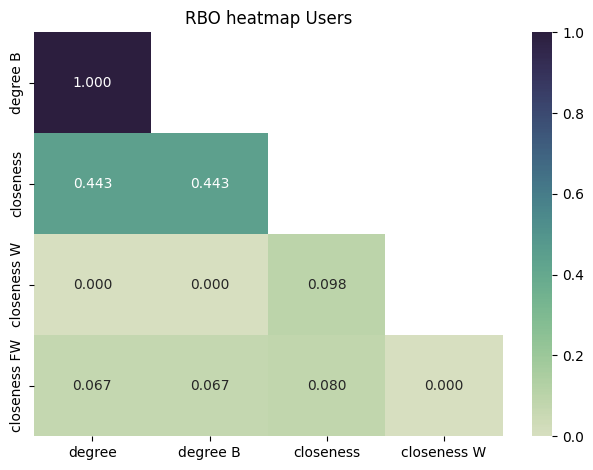

In [ ]:
mycmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
hmap=sns.heatmap(rbo_triangle, cmap=mycmap, annot=True, fmt=".3f")
plt.title('RBO heatmap Users')
plt.tight_layout()
#hmap.figure.savefig("./figures/RBO_heatmap_users.png")

**Anime**

In [ ]:
categories = ['degree', 'degree B', 'closeness', 'closeness W', 'closeness FW', 'global avg rank', 'members']
rbo_values = np.zeros((len(categories), len(categories)), dtype=float)
for i, c_i in enumerate(categories):
  for j, c_j in enumerate(categories):
    rbo_metric = rbo(df_top_anime[c_i].values, df_top_anime[c_j].values)
    rbo_values[i,j] = rbo_metric
    print('RBO {} - {}: {}'.format(c_i, c_j, rbo_metric))

RBO degree - degree: 1.0
RBO degree - degree B: 1.0
RBO degree - closeness: 0.7273950131285715
RBO degree - closeness W: 0.0
RBO degree - closeness FW: 0.5736733460071428
RBO degree - global avg rank: 0.0
RBO degree - members: 0.6925607696928571
RBO degree B - degree: 1.0
RBO degree B - degree B: 1.0
RBO degree B - closeness: 0.7273950131285715
RBO degree B - closeness W: 0.0
RBO degree B - closeness FW: 0.5736733460071428
RBO degree B - global avg rank: 0.0
RBO degree B - members: 0.6925607696928571
RBO closeness - degree: 0.7273950131285715
RBO closeness - degree B: 0.7273950131285715
RBO closeness - closeness: 1.0
RBO closeness - closeness W: 0.0
RBO closeness - closeness FW: 0.4868972518214286
RBO closeness - global avg rank: 0.0
RBO closeness - members: 0.6252807660785714
RBO closeness W - degree: 0.0
RBO closeness W - degree B: 0.0
RBO closeness W - closeness: 0.0
RBO closeness W - closeness W: 1.0
RBO closeness W - closeness FW: 0.0
RBO closeness W - global avg rank: 0.0
RBO clo

In [ ]:
# mask for low triangle
mask1 = np.tril(np.ones(rbo_values.shape)).astype(dtype = bool)
# mask for no diagonal
mask2 = np.ones(len(categories)) - np.identity(len(categories))
mask2 = mask2.astype(dtype = bool)

rbo_triangle = pd.DataFrame(rbo_values).where(np.multiply(mask1, mask2)).iloc[1:,:-1]
rbo_triangle.columns = categories[:-1]
rbo_triangle.index = categories[1:]

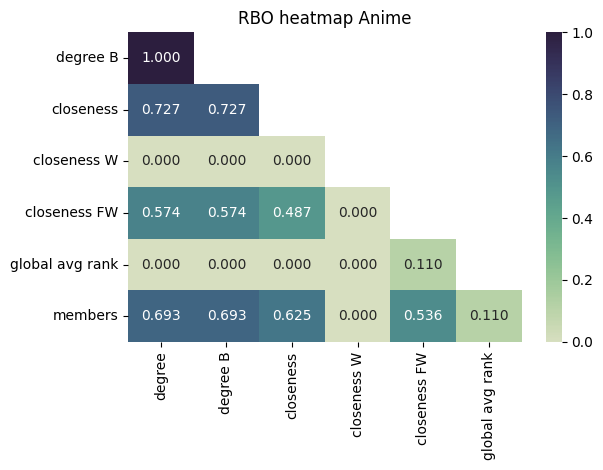

In [ ]:
mycmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
hmap=sns.heatmap(rbo_triangle, cmap=mycmap, annot=True, fmt=".3f")
plt.title('RBO heatmap Anime')
plt.tight_layout()
#hmap.figure.savefig("./figures/RBO_heatmap_anime.png")

**Some final considerations:**



1.Degree centrality computed with and without considering the property of the graph to be bipartite produces the same ranking list, even if the final scores are different.

2.Closeness centrality with graph without weights has a ranking quite similiar to the ones of degree centralies, but the order of some elements are different, while others are some new addition.

3.Closeness centrality with graph with ratings as weight is not really effective. This is due the fact that the weights in this case are rates which refelect how much an user had appreciated a certain item, but if used during the computation of the metric they are seen as distance lossing the original meaning. Indeed the output ranking is rather different compared with the others. For this reason a function 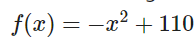
 is used to map ratings into "distances" somehow. For high rates we get low distances and decreasing the rate, the corresponding "distance" climp up.

4.It's interesting to observe that results obtained thanks graph analisys are not the same as sorting the anime by global avarage rating. A possible reason is that while the graph centrality metrics are calculated based on the given user-item interactions, the global avarage rating is, as the name suggests, only a mean value among ratings. Thus an anime watched by a small comunity that really likes it and so having a high global average rating, it may happen that it's not actually one of the most popular items. This assumption is supported by the fact that our metrics compared with the ranking given by sorting the anime by number of members are more similar.

5.It's important to rembember that graph G is huge, therefore computing the exact closeness metric is really difficult in terms of time complexity. For this reason, an approximeted version has been implemented with k=150 empiricaly chosen. It may be that increasing k value, so will happen for the effectiveness of closeness centrality. This is a possibile suggestion when more hardware resources are available.

6.Regarding the time complexity, on one hand degree centrality (for both versions) is really fast to compute, while closeness centrality requires 9 ~
 10 minutes for the unweighted graph and 41/52 minutes for the weighted variants. Therefore considering that these centraly metrics will be used to solve the cold-start problem, a frequent occurance, having an operation that requires so much time, would be quite demanding. Thus degree centrality can be helpful when the operation is done with an high frequency, but if we decide to compute the most popular items to suggest and the most active users only from time to time (updating the values after a certain period has passed), then also closeness centrality could be used.

7.Analogous considerations done on points [1-3] are valid also for the analisys of top k users rankings. Interesting to note that while for anime rankings, closeness FW (closeness centrality with a function of ratings as weights) is similar to degree, degree B, closeness and memebers metrics, the same is not true comparing results for user rankings. A possible reason is that for users degree metrics and closeness centrality without weights, consider the top users the ones which are more active in terms of anime watched. On the other hand closeness with ratings as weights judges the users on the values of rates given. Same for closeness centrality with a function of ratings as weights, but with different final results obviously given by the application of the function f(x).
.



